In [31]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import re
import string

In [34]:
df = pd.read_csv("twitter.csv")
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [35]:
## Répartition du dataset
print((df.target == 1).sum()) # Catastrophe
print((df.target == 0).sum()) # Non

3271
4342


1.Preprocessing

In [36]:
# SI NLTK n'est pas installé pip install NLK
import nltk
# On télécharge les stopwords
nltk.download('stopwords')
# On importe les stopwords
from nltk.corpus import stopwords
# Les données étant en anglais on définit le lanqage des stopwords à utiliser
stop = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yvanfai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
#Fonction supprimant les stopwords
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

# Fonction de suppression des url
def text_cleaning(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)     # Supp @
  text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # Supp @
  text = re.sub(r'@[A-Za-z]+', '', text)        # Supp @
  text = re.sub(r'@[-)]+', '', text)            # Supp @
  text = re.sub(r'#', '', text )                # Supp #
  text = re.sub(r'RT[\s]+', '', text)           # Supp RT
  text = re.sub(r'https?\/\/\S+', '', text)     # Supp Lien
  text = re.sub(r'&[a-z;]+', '', text)          # Supp '&gt;'

  return text

# Fonction de suppression la ponctuation
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

In [38]:
# On supprime les stopwords
df["text"] = df.text.map(remove_stopwords)
# On supprime les URL de nos données
df["text"] = df.text.map(text_cleaning) 
# On supprime la ponctuation
df["text"] = df.text.map(remove_punct)

In [39]:
df.text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ahrary  control wild fires california even nor...
7610    m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [40]:
from collections import Counter
# Fonction retournant le nombre de mot unique
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count
counter = counter_word(df.text)

2.Tokenization

In [41]:
# On stocke le nombre de mot unique on s'en servira plus tard
num_unique_words = len(counter)

In [13]:
#Number of unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count
counter = counter_word(df.text)  
counter

Counter({'-': 780,
         'like': 342,
         'im': 298,
         'get': 229,
         'fire': 226,
         'new': 224,
         'via': 220,
         'news': 193,
         'people': 185,
         'one': 185,
         'video': 163,
         '2': 153,
         '...': 152,
         'emergency': 149,
         'disaster': 141,
         'police': 136,
         'would': 130,
         'still': 129,
         'body': 122,
         'burning': 117,
         'suicide': 115,
         'crash': 114,
         'back': 114,
         'us': 113,
         'got': 112,
         'california': 109,
         'rt': 108,
         'man': 106,
         'know': 106,
         'first': 106,
         'storm': 106,
         'see': 103,
         'going': 103,
         'cant': 102,
         'buildings': 102,
         '3': 101,
         'nuclear': 101,
         'love': 100,
         'day': 100,
         'time': 98,
         'two': 97,
         'bomb': 97,
         'killed': 96,
         'world': 93,
         'go': 92,


In [42]:
# On sépare notre dataset en jeu d'entairenement et de validation
from sklearn.model_selection import train_test_split

train_df,val_df = train_test_split(df,test_size=0.2)


# On sépare les données de la cible et on créé des tableaux pour stocker tout ça

train_phrases = train_df.text.to_numpy()
train_labels = train_df.target.to_numpy()
val_phrases = val_df.text.to_numpy()
val_labels = val_df.target.to_numpy()

In [43]:
# Tokenize
from keras.preprocessing.text import Tokenizer

# On transforme nos mots en vecteurs d'entier
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_phrases) 

In [44]:
# On transforme nos phrases en séquences d'entier
train_sequences = tokenizer.texts_to_sequences(train_phrases)
val_sequences = tokenizer.texts_to_sequences(val_phrases)

In [45]:
print(train_phrases[1])
print(train_sequences[1])

love song healing heredeluge  sing church spanish translated it httptcodmrsyeiqz3
[30, 517, 5756, 5757, 1918, 1498, 2271, 5758, 86, 5759]


In [47]:
# On importe de tensorFlow
from keras.preprocessing.sequence import pad_sequences
# On définit la longueur max de chaque séquence.
max_length = 20
# On "pad" nos phrases
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")

val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [48]:
# Vérification
print(train_phrases[1])
print(train_sequences[1])
print(train_padded[1])

love song healing heredeluge  sing church spanish translated it httptcodmrsyeiqz3
[30, 517, 5756, 5757, 1918, 1498, 2271, 5758, 86, 5759]
[  30  517 5756 5757 1918 1498 2271 5758   86 5759    0    0    0    0
    0    0    0    0    0    0]


In [49]:
# Fonction de decryptage
def decode(sequence):
    return " ".join([word_index.get(idx, "?") for idx in sequence])

3.Creating Model

In [50]:
word_index = tokenizer.word_index
word_index = reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
decoded_text = decode(train_sequences[1])

print(train_sequences[1])
print(decoded_text)

[30, 517, 5756, 5757, 1918, 1498, 2271, 5758, 86, 5759]
love song healing heredeluge sing church spanish translated it httptcodmrsyeiqz3


In [51]:
from tensorflow.keras import layers

In [52]:
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

model.add(layers.LSTM(64, dropout=0.5))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 32)            659872    
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 684769 (2.61 MB)
Trainable params: 684769 (2.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [55]:
r = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/20
191/191 - 10s - loss: 0.5676 - accuracy: 0.6860 - val_loss: 0.4900 - val_accuracy: 0.7905 - 10s/epoch - 54ms/step
Epoch 2/20
191/191 - 5s - loss: 0.3324 - accuracy: 0.8644 - val_loss: 0.4756 - val_accuracy: 0.7892 - 5s/epoch - 27ms/step
Epoch 3/20
191/191 - 5s - loss: 0.2085 - accuracy: 0.9190 - val_loss: 0.6744 - val_accuracy: 0.7774 - 5s/epoch - 27ms/step
Epoch 4/20
191/191 - 6s - loss: 0.1288 - accuracy: 0.9519 - val_loss: 0.6677 - val_accuracy: 0.7748 - 6s/epoch - 31ms/step
Epoch 5/20
191/191 - 5s - loss: 0.0888 - accuracy: 0.9673 - val_loss: 0.6929 - val_accuracy: 0.7774 - 5s/epoch - 26ms/step
Epoch 6/20
191/191 - 5s - loss: 0.0692 - accuracy: 0.9762 - val_loss: 0.7617 - val_accuracy: 0.7676 - 5s/epoch - 25ms/step
Epoch 7/20
191/191 - 5s - loss: 0.0636 - accuracy: 0.9800 - val_loss: 0.7315 - val_accuracy: 0.7636 - 5s/epoch - 26ms/step
Epoch 8/20
191/191 - 5s - loss: 0.0458 - accuracy: 0.9841 - val_loss: 0.9121 - val_accuracy: 0.7715 - 5s/epoch - 26ms/step
Epoch 9/20
191

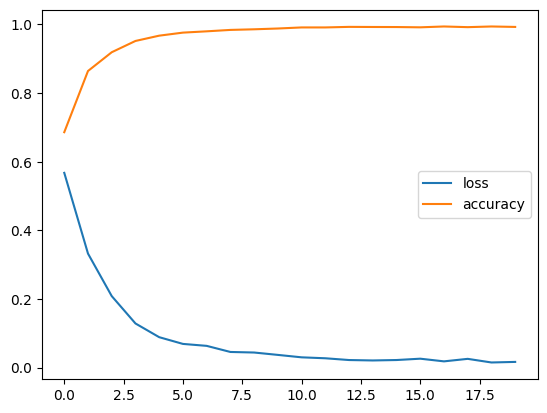

In [56]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.legend()

In [57]:
def predict_catastrophe(text):
  # preprocessing the given text 
  text = text_cleaning(text[0])
  text = remove_punct(text)
  text = remove_stopwords(text)
  
  text_seq = tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=20)
  print(text_pad)
  # predicting the class
  predicted_sentiment = model.predict(text_pad)
  print(predicted_sentiment[0].round())
 

In [59]:
predict_catastrophe(["big fire in forest "])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  644]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  483]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 3737]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 1691]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  483]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  815]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 1315]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    

[0.]
